# Classificando HPAs

Percorre os arquivos baixados por `hpa_usage.ipynb` no diretório `search_results` e classifica-os de acordo com suas características.

In [27]:
import os
import subprocess
import re
import yaml
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
plt.style.use('bmh')

## Definição de funções

In [5]:
def is_helm_template(content):
  # Detects Helm template patterns in the file content
  return bool(re.search(r'{{.*}}', content))

def parse_yaml_documents(content):
  # Parses YAML content into a list of documents
  try:
    return list(yaml.safe_load_all(content))
  except yaml.YAMLError:
    return []

def extract_metrics_from_spec(spec, debug=False):
  # Extracts metric information from the HPA spec
  metrics_info = []
  metrics = spec.get('metrics', [])
  if debug:
    print("Extracting metrics")
    print(metrics)
  
  for metric in metrics:
    if isinstance(metric, str):
      metrics_info.append({
        'Metric Name': metric,
        'Metric Type': metric,
        'Target Value': metrics[metric]
      })
    elif not 'type' in metric:
      metrics_info.append({
        'Metric Name': 'CPUUtilizationPercentage',
        'Metric Type': 'CPUUtilizationPercentage',
        'Target Value': spec['CPUUtilizationPercentage']
      })
    else:
      if debug:
        print(f"type {metric.get('type', 'NA')}")
      metric_type = metric.get('type', '')
      metric_details = metric.get(metric_type.lower(), {})
      target = metric_details.get('target', {})
      target_value = target.get('averageValue') or target.get('averageUtilization') or target.get('targetAverageUtilization') or target.get('value')

      metric_name = ''
      if metric_type.lower() == 'resource':
        metric_name = metric_details.get('name', '')
      else:
        metric_name = metric_details.get('metric', {}).get('name', '')

      metrics_info.append({
        'Metric Name': metric_name,
        'Metric Type': metric_type,
        'Target Value': target_value
      })
  if not metrics:
    if 'targetCPUUtilizationPercentage' in spec:
      metrics_info.append({
        'Metric Name': 'targetCPUUtilizationPercentage',
        'Metric Type': 'targetCPUUtilizationPercentage',
        'Target Value': spec['targetCPUUtilizationPercentage']
      })
    if 'cpuUtilization' in spec:
      metrics_info.append({
        'Metric Name': 'cpuUtilization',
        'Metric Type': 'cpuUtilization',
        'Target Value': spec['cpuUtilization']['targetPercentage']
      })
  return metrics_info

def extract_behavior_from_spec(spec, debug=False):
  scale_up = spec.get('scaleUp', None)
  scale_down = spec.get('scaleDown', None)

  if debug:
    print(f"scale_up: {scale_up}")
    print(f"scale_down: {scale_down}")
  
  if scale_up == None and scale_down == None:
    if debug:
      print("returning None")
    return None

  if debug:
    print("filling behavior")

  result = {
    "scaleUp": None,
    "scaleDown": None
  }

  if scale_up:
    result["scaleUp"] = {
      "stab_window": scale_up.get('stabilizationWindowSeconds', None),
      "select_pol": scale_up.get('selectPolicy', None),
      "policies": [{
        "type": p.get('type', ''),
        "value": p.get('value', 0),
        "periodSeconds": p.get('periodSeconds', 0)
      } for p in scale_up.get('policies')]
    }
  
  if scale_down:
    result["scaleDown"] = {
      "stab_window": scale_down.get('stabilizationWindowSeconds', None),
      "select_pol": scale_down.get('selectPolicy', None),
      "policies": [{
        "type": p.get('type', ''),
        "value": p.get('value', 0),
        "periodSeconds": p.get('periodSeconds', 0)
      } for p in scale_down.get('policies')]
    }

  return result


def process_yaml_content(content, debug=False):
  helm_template = is_helm_template(content)

  if helm_template:
    return [{
      'hpa_count': 0,
      'apiVersion': None,
      'Is Helm Template': True
    }]

  documents = parse_yaml_documents(content)
  if debug:
    print(f"Found {len(documents)} documents")
  hpa_definitions = []

  for doc in documents:
    if isinstance(doc, dict) and doc.get('kind') == 'HorizontalPodAutoscaler':
      if debug:
        print(f"Found hpa #{len(hpa_definitions)+1}")
      api_version = doc.get('apiVersion', '')
      spec = doc.get('spec', {})
      
      metrics = extract_metrics_from_spec(spec, debug)
      behavior = extract_behavior_from_spec(spec, debug)
      if debug:
        print(f"with {len(metrics)} metrics")
      hpa_definitions.append({
        'hpa_count': len(hpa_definitions)+1,
        'apiVersion': api_version,
        'Is Helm Template': helm_template,
        'Metrics': metrics,
        'Behavior': behavior
      })
  return hpa_definitions

def process_yaml_file(file_path, debug=False):
  # Processes a single YAML file to extract HPA definitions and metrics
  if debug:
    print(f"Processing {file_path}")
  with open(file_path, 'r') as f:
    content = f.read()
    return process_yaml_content(content, debug=debug)
    
def map_version(api_version):
  # Etiqueta versão do HPA
  # Tudo que contém 'v1' e não contém 'v2' será considerado v1.
  # Caso contrário, consideraprint(f"Failed to process: {file_path}")mos v2.
  if 'v1' in api_version and 'v2' not in api_version:
    return 'v1'
  else:
    return 'v2'

def add_labels(plt, x, y, hpadding=0):
  for i in range(len(x)):
    plt.text(i, y[i]+hpadding, y[i], ha = 'center')
      

## Percorre projetos

In [6]:
metrics_data = []
behavior_data = []
root_dir = 'search_results'
processing_failed = []

for dirpath, dirnames, filenames in os.walk(root_dir):
  for filename in filenames:
    file_path = os.path.join(dirpath, filename)
    
    rel_path = os.path.relpath(dirpath, root_dir)
    path_parts = rel_path.split(os.sep)

    owner = None
    project = None
    rest = None

    if len(path_parts) >= 2:
      owner = path_parts[0]
      project = path_parts[1]
      rest = os.sep.join(path_parts[2:])
    file_subpath = os.path.join(rest, filename)
    
    try:
      hpa_definitions = process_yaml_file(file_path)
    except:
      print(f"Error processing {file_path}")
      hpa_definitions = []
    for hpa in hpa_definitions:
      has_behavior = 'Behavior' in hpa and hpa['Behavior'] is not None
      # metrics
      if not 'Metrics' in hpa:
        metrics_data.append({
          'Owner': owner,
          'Project': project,
          'File Path': file_path,
          'hpa_count': hpa['hpa_count'],
          'apiVersion': hpa['apiVersion'],
          'Is Helm Template': hpa['Is Helm Template'],
          'Metric Name': None,
          'Metric Type': None,
          'Target Value': None,
          'Has Behavior': has_behavior
        })
      else:
        metrics = hpa['Metrics']
        for metric in metrics:
          metrics_data.append({
            'Owner': owner,
            'Project': project,
            'File Path': file_path,
            'hpa_count': hpa['hpa_count'],
            'apiVersion': hpa['apiVersion'],
            'Is Helm Template': hpa['Is Helm Template'],
            'Metric Name': metric['Metric Name'],
            'Metric Type': metric['Metric Type'],
            'Target Value': metric['Target Value'],
            'Has Behavior': has_behavior
          })
        if not metrics:
          metrics_data.append({
            'Owner': owner,
            'Project': project,
            'File Path': file_path,
            'hpa_count': hpa['hpa_count'],
            'apiVersion': hpa['apiVersion'],
            'Is Helm Template': hpa['Is Helm Template'],
            'Metric Name': None,
            'Metric Type': None,
            'Target Value': None,
            'Has Behavior': has_behavior
          })
    if not hpa_definitions:
      processing_failed.append(file_path)
      metrics_data.append({
        'Owner': owner,
        'Project': project,
        'File Path': file_path,
        'Is Helm Template': None,
        'Metric Name': None,
        'Metric Type': None,
        'Target Value': None,
        'Has Behavior': False
      })

# display(processing_failed)

Error processing search_results/Eldarrin/deepsea/src/main/fabric8/HorizontalPodAutoscaler.yml
Error processing search_results/tyokinuhata/tiny-programs/k8s/horizontal_pod_autoscaler/hpa.yaml


In [7]:
df = pd.DataFrame(metrics_data)

df['hpa_count'] = df['hpa_count'].fillna(0).apply(lambda x: int(x))

display(df)

,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior
0,hackclub,replit-lifeboat,search_results/hackclub/replit-lifeboat/hpa.yaml,1,autoscaling/v2,False,cpu,Resource,50,False
1,haydercyber,DevOps1,search_results/haydercyber/DevOps1/piktochart/...,0,None,True,None,None,None,False
2,bgastaldi,myapp,search_results/bgastaldi/myapp/k8s/06_hpa.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,20,False
3,bgastaldi,myapp,search_results/bgastaldi/myapp/k8s/bkp/11_hpa_...,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,20,False
4,sul-dlss,okapi-folio-helm,search_results/sul-dlss/okapi-folio-helm/setae...,0,None,True,None,None,None,False
...,...,...,...,...,...,...,...,...,...,...
3787,nforgeio,neonKUBE,search_results/nforgeio/neonKUBE/Lib/Neon.Kube...,0,None,True,None,None,None,False
3788,tmax-cloud,hypercloud-console5.0,search_results/tmax-cloud/hypercloud-console5....,0,NaN,None,None,None,None,False
3789,ourlaf8,helmtixia,search_results/ourlaf8/helmtixia/charts/chartg...,0,None,True,None,None,None,False
3790,fortinet,k8s-fortigate-ctrl,search_results/fortinet/k8s-fortigate-ctrl/exa...,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,60,False


In [8]:
filter_nohelm = df[df['Is Helm Template'] == False]

display(filter_nohelm)

,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior
0,hackclub,replit-lifeboat,search_results/hackclub/replit-lifeboat/hpa.yaml,1,autoscaling/v2,False,cpu,Resource,50,False
2,bgastaldi,myapp,search_results/bgastaldi/myapp/k8s/06_hpa.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,20,False
3,bgastaldi,myapp,search_results/bgastaldi/myapp/k8s/bkp/11_hpa_...,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,20,False
6,tadeubdev,wppconnect-php,search_results/tadeubdev/wppconnect-php/k8s/06...,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,20,False
7,tadeubdev,wppconnect-php,search_results/tadeubdev/wppconnect-php/k8s/bk...,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,20,False
...,...,...,...,...,...,...,...,...,...,...
3780,happinesslijian,k8s-application,search_results/happinesslijian/k8s-application...,1,autoscaling/v2beta1,False,memory,Resource,None,False
3781,happinesslijian,k8s-application,search_results/happinesslijian/k8s-application...,2,autoscaling/v2beta1,False,cpu,Resource,None,False
3782,happinesslijian,k8s-application,search_results/happinesslijian/k8s-application...,2,autoscaling/v2beta1,False,memory,Resource,None,False
3790,fortinet,k8s-fortigate-ctrl,search_results/fortinet/k8s-fortigate-ctrl/exa...,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,60,False


In [46]:
print(f"{filter_nohelm[['Owner', 'Project', 'File Path']].drop_duplicates().shape[0]} arquivos")
print(f"{filter_nohelm[['Owner', 'Project']].drop_duplicates().shape[0]} projetos")
print(f"{filter_nohelm['Owner'].drop_duplicates().shape[0]} autores")

display(filter_nohelm[filter_nohelm['Has Behavior']!=False])

1587 arquivos
1334 projetos
1224 autores


,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior


,,File Path
Owner,Project,
DanielForsell,DevOps_With_Kubernetes,14


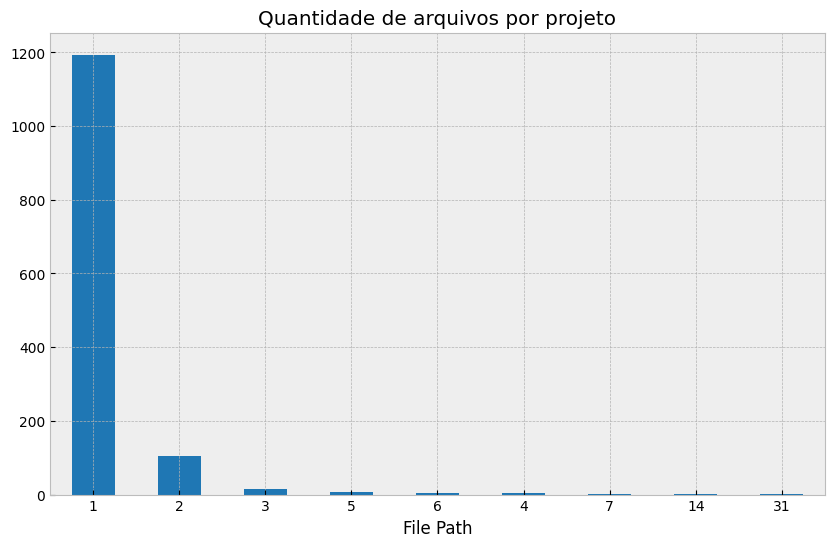

In [43]:
files_per_project = filter_nohelm[['Owner', 'Project', 'File Path']].drop_duplicates()

files_counts = files_per_project.groupby(['Owner', 'Project']).count()

files_counts_values = files_counts['File Path'].value_counts()

display(files_counts[files_counts['File Path']==14])

plt.figure(figsize=(10,6))
ax = files_counts_values.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='tab20')
ax.tick_params(axis="x", rotation=0)
plt.title("Quantidade de arquivos por projeto")
plt.show()

1861

search_results/gehadgkamel/deploy_eks/k8s/manifests/3-hpa/3-hpa.yaml


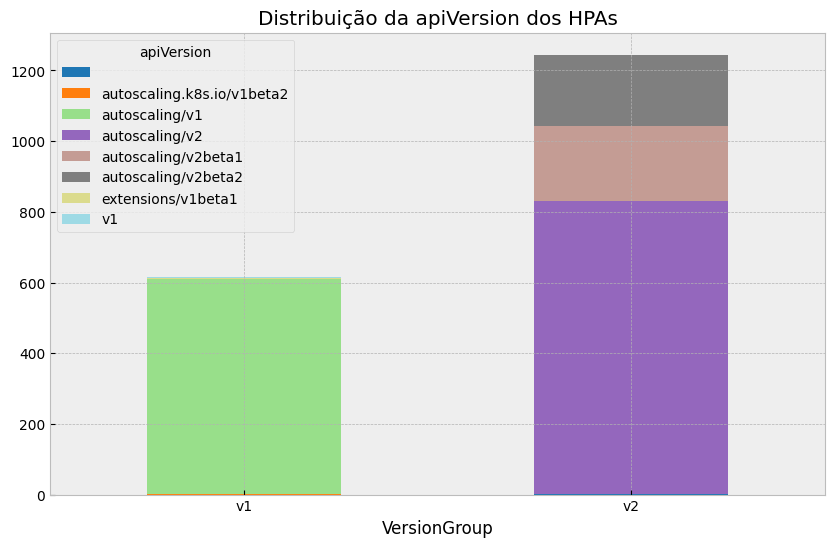

apiVersion,,autoscaling.k8s.io/v1beta2,autoscaling/v1,autoscaling/v2,autoscaling/v2beta1,autoscaling/v2beta2,extensions/v1beta1,v1,Total
VersionGroup,,,,,,,,,
v1,0.0,1.0,608.0,0.0,0.0,0.0,5.0,2.0,616.0
v2,1.0,0.0,0.0,829.0,214.0,201.0,0.0,0.0,1245.0


In [136]:
df_hpa_defs = filter_nohelm[['Owner', 'Project', 'File Path', 'hpa_count', 'apiVersion']].drop_duplicates()

display(df_hpa_defs.shape[0])
print(df_hpa_defs[df_hpa_defs['apiVersion']==''].iloc[0]['File Path'])

version_counts = df_hpa_defs['apiVersion'].value_counts().sort_index()
df_grouped = pd.DataFrame({'apiVersion': version_counts.index, 'count': version_counts.values})

df_grouped['VersionGroup'] = df_grouped['apiVersion'].apply(func=map_version)

pivot_versions = df_grouped.pivot(index='VersionGroup', columns='apiVersion', values='count').fillna(0)

plt.style.use('bmh')
plt.figure(figsize=(10,6))
ax = pivot_versions.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='tab20')
ax.tick_params(axis="x", rotation=0)
plt.title("Distribuição da apiVersion dos HPAs")
plt.show()

pivot_versions['Total'] = pivot_versions.sum(axis=1)
display(pivot_versions)


'search_results/solo-io/service-mesh-for-less-blog/tiered-app/30-namespace-app/ambient/waypoints/hpa-per-namespace.yaml'

'search_results/mendoncas/onlineboutique/distributed.yaml'

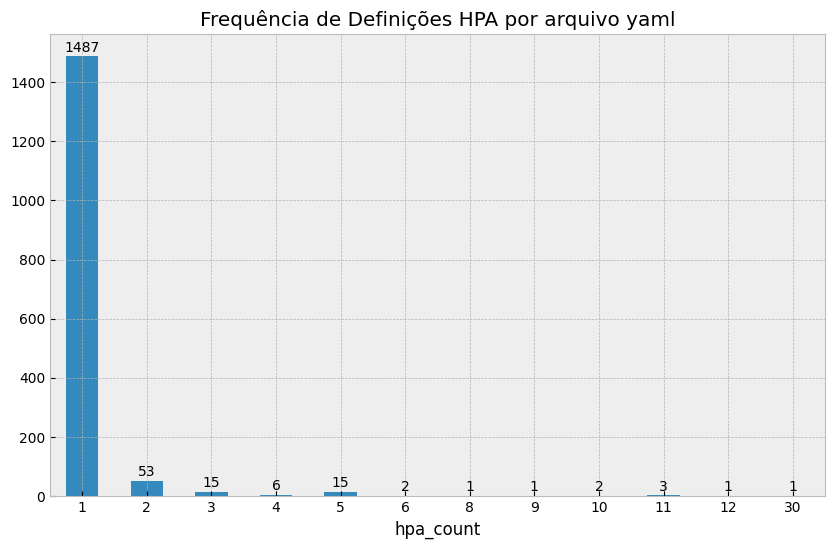

In [137]:
# Definições de HPA por arquivo

filter_nohelm_nodups = (
  filter_nohelm
  .sort_values('hpa_count', ascending=False)
  .drop_duplicates(subset=['Owner', 'Project', 'File Path'], keep='first')
)

display(filter_nohelm_nodups[filter_nohelm_nodups['hpa_count']==30].iloc[0]['File Path'])
display(filter_nohelm_nodups[filter_nohelm_nodups['hpa_count']==11].iloc[1]['File Path'])

hpa_counts = filter_nohelm_nodups['hpa_count'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
ax = hpa_counts.plot(kind='bar')
add_labels(plt, hpa_counts.index, hpa_counts.values, hpadding=16)
ax.tick_params(axis="x", rotation=0)
plt.title("Frequência de Definições HPA por arquivo yaml")
plt.show()


1861

,File Path,hpa_count,Metric Type count
67,search_results/CS3219-AY2223S1/cs3219-project-...,1,0
218,search_results/JasonMorgan/linkerd-demos/gitop...,1,0
340,search_results/PawaraGunathilaka/a-skyu-gitops...,1,0
341,search_results/PawaraGunathilaka/a-skyu-gitops...,1,0
345,search_results/PiggyMetrics/PiggyMetrics/k8s/a...,1,0
...,...,...,...
1536,search_results/smplverse/kube/api.yaml,1,0
1699,search_results/tkkawa/twitter-manifests/sample...,1,0
1767,search_results/viniciusfcf/hpa-jvm-gc-demo/hpa...,1,0
1796,search_results/wbrown-ping/ping-cloud-base/cod...,1,0


'search_results/weibaohui/k8s-playgrounds/yaml/resource/hpa/hpa.yaml'

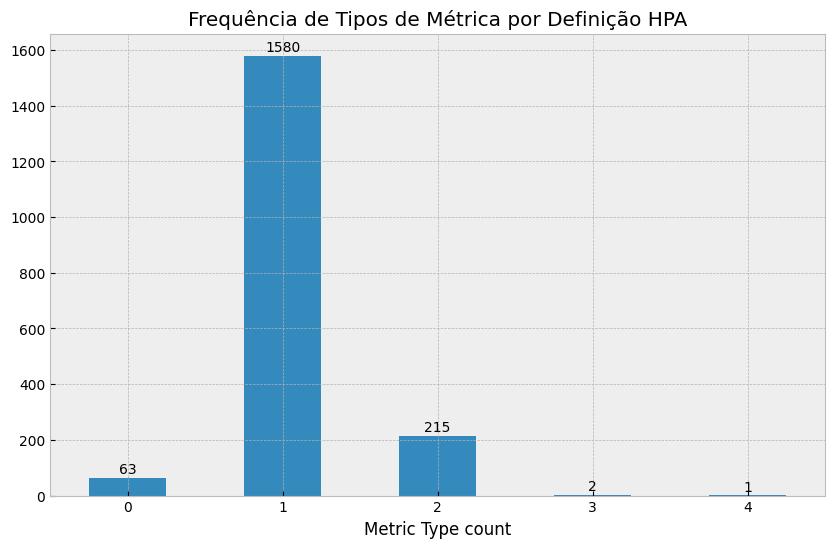

In [141]:
# Tipos de métrica por definição HPA

files_n_def = filter_nohelm[['File Path', 'hpa_count']].drop_duplicates()
display(files_n_def.shape[0])

metrics_per_def = filter_nohelm.groupby(['File Path', 'hpa_count'])['Metric Type'].count().reset_index(name='Metric Type count')
display(metrics_per_def[metrics_per_def['Metric Type count'] == 0])
display(metrics_per_def[metrics_per_def['Metric Type count'] == 4].iloc[0]['File Path'])

metrics_counts = metrics_per_def['Metric Type count'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = metrics_counts.plot(kind='bar')
add_labels(plt, metrics_counts.index, metrics_counts.values, hpadding=16)
ax.tick_params(axis="x", rotation=0)
plt.title("Frequência de Tipos de Métrica por Definição HPA")
plt.show()


1464

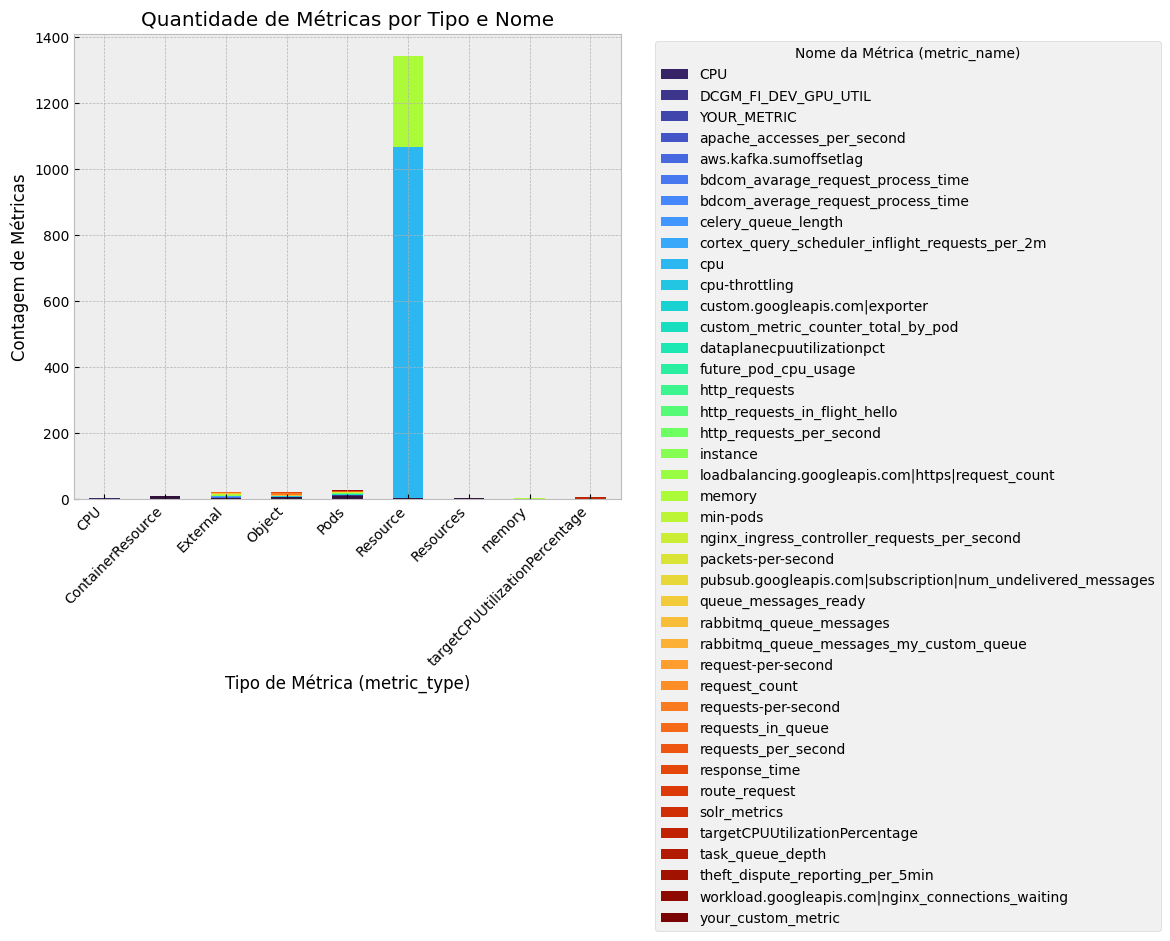

In [82]:
df_v2 = filter_nohelm[filter_nohelm['apiVersion'].str.contains('v2')]
display(df_v2.shape[0])

v2_metrics = df_v2.groupby(['Metric Type', 'Metric Name']).size().reset_index(name='counts')

pivot_table = v2_metrics.pivot(index='Metric Type', columns='Metric Name', values='counts').fillna(0)

plt.figure(figsize=(12, 8))
pivot_table.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='turbo')
plt.title('Quantidade de Métricas por Tipo e Nome')
plt.xlabel('Tipo de Métrica (metric_type)')
plt.ylabel('Contagem de Métricas')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nome da Métrica (metric_name)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior
244,weibaohui,k8s-playgrounds,search_results/weibaohui/k8s-playgrounds/yaml/...,1,autoscaling/v2,False,queue_messages_ready,External,30,False
288,mauriciocarvalho01,FIAP-Tech-Challenge-Restaurante-Acme-Orders,search_results/mauriciocarvalho01/FIAP-Tech-Ch...,1,autoscaling/v2,False,rabbitmq_queue_messages,External,10,False
348,gjtempleton,k8s-autoscaling-by-example,search_results/gjtempleton/k8s-autoscaling-by-...,1,autoscaling/v2beta2,False,rabbitmq_queue_messages,External,10,False
444,FANKAO-PROJECTS,Development-Toolkit,search_results/FANKAO-PROJECTS/Development-Too...,1,autoscaling/v2,False,loadbalancing.googleapis.com|https|request_count,External,5,False
515,candidoma,testhpa,search_results/candidoma/testhpa/nginx/hpa_ext...,1,autoscaling/v2beta2,False,YOUR_METRIC,External,YOUR_VALUE,False
520,warroyo,tmc-tap-eks-guide,search_results/warroyo/tmc-tap-eks-guide/confi...,1,autoscaling/v2,False,aws.kafka.sumoffsetlag,External,30,False
902,WilliamDenniss,kubernetes-for-developers,search_results/WilliamDenniss/kubernetes-for-d...,1,autoscaling/v2,False,loadbalancing.googleapis.com|https|request_count,External,5,False
945,jrhuerta,celery-k8s-suffle-shard-with-autoscaling,search_results/jrhuerta/celery-k8s-suffle-shar...,1,autoscaling/v2beta2,False,celery_queue_length,External,50,False
1323,prompted365,sunlink,search_results/prompted365/sunlink/sunlink-wor...,1,autoscaling/v2,False,task_queue_depth,External,5,False
1358,wavefrontHQ,wavefront-kubernetes-adapter,search_results/wavefrontHQ/wavefront-kubernete...,1,autoscaling/v2beta2,False,,External,None,False


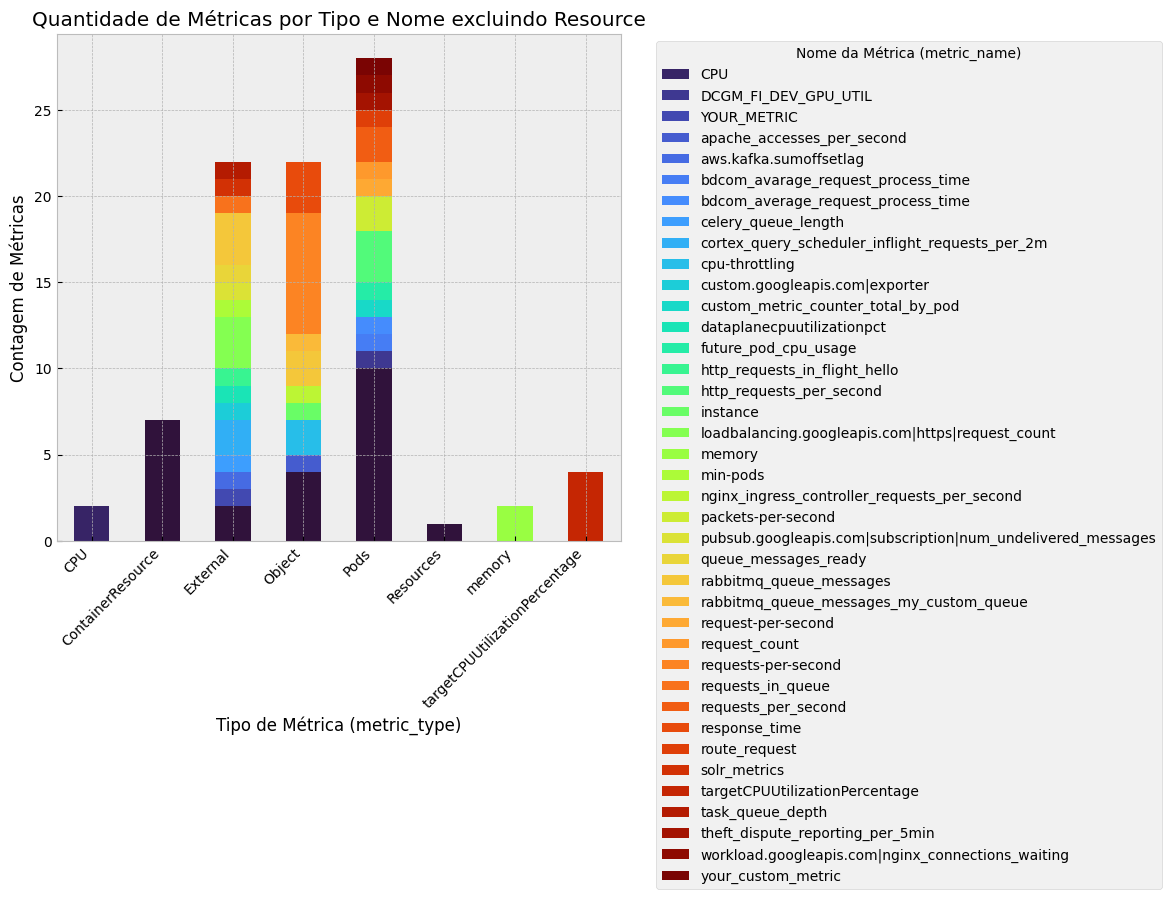

In [147]:
df_v2 = filter_nohelm[filter_nohelm['apiVersion'].str.contains('v2')]

df_v2_no_resource = df_v2[df_v2['Metric Type'] != 'Resource']

display(df_v2_no_resource[df_v2_no_resource['Metric Type']=='External'])

v2_metrics = df_v2_no_resource.groupby(['Metric Type', 'Metric Name']).size().reset_index(name='counts')

pivot_table = v2_metrics.pivot(index='Metric Type', columns='Metric Name', values='counts').fillna(0)

plt.figure(figsize=(12, 8))
pivot_table.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='turbo')
plt.title('Quantidade de Métricas por Tipo e Nome excluindo Resource')
plt.xlabel('Tipo de Métrica (metric_type)')
plt.ylabel('Contagem de Métricas')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nome da Métrica (metric_name)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
